In [148]:
import pandas as pd
import numpy as np

In [149]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


In [150]:
class Data:
    def __init__(self, path: str) -> None:    
        demand_path = path + "/Demand_history.csv"
        existingEV_path = path + "/existing_EV_infrastructure_2018.csv"
        self.df_orig = pd.read_csv(demand_path)
        self.df_trans = self.df_orig
        
    def clean(self):
        self.df_orig.loc[(self.df_orig!=0).any(1)]
        print(self.df_orig)
        
    def split(self):
        x_train = pd.DataFrame(columns=["x_coordinate", "y_coordinate", "n-2", "n-1"])
        x_test = pd.DataFrame(columns=["x_coordinate", "y_coordinate", "n-2", "n-1"])
        y_train = pd.Series(dtype=np.float64)
        y_test = pd.Series(dtype=np.float64)
        for y in self.df_trans.columns[self.df_trans.columns.str.startswith('20')]:
            y = int(y)
            if y < 2012:
                continue
            stack_x = self.df_trans.loc[:, self.df_trans.columns.isin(["x_coordinate", "y_coordinate", f"{y - 2}", f"{y - 1}"])]
            stack_x = stack_x.rename(columns={f"{y - 2}": "n-2", f"{y - 1}": "n-1"})
            # stack_x['year'] = y
            # stack_x['year'] = pd.to_numeric(stack_x['year'])
            stack_y = self.df_trans.loc[:, f"{y}"]
            if y == 2018:
                 x_test = pd.concat([x_test, stack_x], axis=0, ignore_index=True)
                 y_test = pd.concat([y_test, stack_y], axis=0, ignore_index=True)
            else:
                x_train = pd.concat([x_train, stack_x], axis=0, ignore_index=True)
                y_train = pd.concat([y_train, stack_y], axis=0, ignore_index=True)
        
        data.x_train = x_train
        data.x_test = x_test
        data.y_train = y_train
        data.y_test = y_test
        
    def addYearDemandfromForecast(self, year: int, predicted: np.array) -> None:
        predicted = predicted.reshape(-1, 1)
        self.df_trans[f"{year}"] = predicted        
                  
path = "data"
data = Data(path)
data.split()

In [151]:
class Model:
    def __init__(self, data: Data) -> None:
        self.data = data
        self.model = xgb.XGBRegressor()
    
    def feature_importance(self) -> None:
        _ = xgb.plot_importance(self.model, height=0.9)
    
    def fit(self) -> None:
        self.model.fit(data.x_train, data.y_train,
            eval_set=[(data.x_train, data.y_train), (data.x_test, data.y_test)],
            early_stopping_rounds=10)
    
    def predict(self, year: int) -> pd.Series:
        x_forecast = \
            data.df_trans.loc[:,
                              data.df_trans.columns.isin(["x_coordinate", "y_coordinate", f"{year - 2}", f"{year - 1}"])]
        # x_forecast['year'] = year          
        return self.model.predict(x_forecast)
    
    def set_params(self, params):
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        self.model.set_params(**params)
        

In [152]:
model = Model(data)

In [153]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform("n_estimators", 100, 1000, 10),
        'seed': 0,
        'objective': 'reg:squarederror'
    }

def objective(space):
    model.set_params(space)
    
    evaluation = [(data.x_train, data.y_train), (data.x_test, data.y_test)]
    
    model.model.fit(data.x_train, data.y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10, verbose=False)
    

    pred = model.predict(2018)
    rmse = mean_squared_error(data.y_test, pred)
    print ("mse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK }

In [154]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                   
249.2610274244484                                      
  1%|          | 1/100 [00:00<00:43,  2.30trial/s, best loss: 249.2610274244484]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                            
240.90202987669983                                                              
  2%|▏         | 2/100 [00:00<00:46,  2.13trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                             
257.4394280582759                                                                
  3%|▎         | 3/100 [00:01<00:50,  1.93trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                             
272.11202063382865                                                               
  4%|▍         | 4/100 [00:01<00:44,  2.17trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                             
244.14017425108045                                                               
  5%|▌         | 5/100 [00:02<00:41,  2.31trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                             
256.4069289094956                                                                
  6%|▌         | 6/100 [00:02<00:47,  1.97trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                             
264.9476298845866                                                                
  7%|▋         | 7/100 [00:03<00:41,  2.23trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                             
254.82848293249594                                                               
  8%|▊         | 8/100 [00:03<00:38,  2.37trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                             
250.5887303275382                                                                
  9%|▉         | 9/100 [00:04<00:43,  2.09trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                             
242.91765328819073                                                               
 10%|█         | 10/100 [00:04<00:41,  2.17trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
269.1637814052601                                                                 
 11%|█         | 11/100 [00:04<00:37,  2.40trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
265.9959308775314                                                                 
 12%|█▏        | 12/100 [00:05<00:40,  2.18trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
247.0199504279583                                                                 
 13%|█▎        | 13/100 [00:05<00:38,  2.27trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
267.91344452860415                                                                
 14%|█▍        | 14/100 [00:06<00:40,  2.10trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
265.5989653108653                                                                 
 15%|█▌        | 15/100 [00:06<00:34,  2.48trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
248.97331093615207                                                                
 16%|█▌        | 16/100 [00:07<00:41,  2.03trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
241.2323255556521                                                                 
 17%|█▋        | 17/100 [00:08<00:44,  1.87trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
266.62981619259665                                                                
 18%|█▊        | 18/100 [00:08<00:47,  1.73trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
255.7121453586634                                                                 
 19%|█▉        | 19/100 [00:09<00:43,  1.86trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
273.5692178089752                                                                 
 20%|██        | 20/100 [00:09<00:45,  1.77trial/s, best loss: 240.90202987669983]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
235.69715748148073                                                                
 21%|██        | 21/100 [00:10<00:45,  1.75trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
243.0291794737649                                                                 
 22%|██▏       | 22/100 [00:11<00:46,  1.68trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
282.2909163244228                                                                 
 23%|██▎       | 23/100 [00:11<00:49,  1.57trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
238.3264973172673                                                                 
 24%|██▍       | 24/100 [00:12<00:46,  1.65trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
238.26182171457953                                                                
 25%|██▌       | 25/100 [00:12<00:46,  1.61trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
279.5304774027987                                                                 
 26%|██▌       | 26/100 [00:13<00:46,  1.60trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
278.22181842870765                                                                
 27%|██▋       | 27/100 [00:14<00:46,  1.56trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
250.9868680609117                                                                 
 28%|██▊       | 28/100 [00:14<00:47,  1.53trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
243.78420774975118                                                                
 29%|██▉       | 29/100 [00:15<00:43,  1.62trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
249.82010034309212                                                                
 30%|███       | 30/100 [00:16<00:41,  1.67trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
274.2586142582226                                                                 
 31%|███       | 31/100 [00:16<00:43,  1.58trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
253.38757161383967                                                                
 32%|███▏      | 32/100 [00:17<00:42,  1.60trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
274.71373774902145                                                                
 33%|███▎      | 33/100 [00:17<00:42,  1.59trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
245.2469577376724                                                                 
 34%|███▍      | 34/100 [00:18<00:41,  1.59trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
247.8979195948099                                                                 
 35%|███▌      | 35/100 [00:19<00:40,  1.61trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
275.06004813089936                                                                
 36%|███▌      | 36/100 [00:19<00:38,  1.66trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
245.28935946367875                                                                
 37%|███▋      | 37/100 [00:20<00:36,  1.70trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
251.97092646553241                                                                
 38%|███▊      | 38/100 [00:20<00:37,  1.65trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
269.154712492001                                                                  
 39%|███▉      | 39/100 [00:21<00:37,  1.62trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
251.15040164653126                                                                
 40%|████      | 40/100 [00:22<00:37,  1.59trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
272.6590734886102                                                                 
 41%|████      | 41/100 [00:22<00:36,  1.60trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
259.65210528089233                                                                
 42%|████▏     | 42/100 [00:23<00:33,  1.73trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
250.2154610629092                                                                 
 43%|████▎     | 43/100 [00:24<00:35,  1.59trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
253.0145854455315                                                                 
 44%|████▍     | 44/100 [00:24<00:32,  1.70trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
262.8272427884434                                                                 
 45%|████▌     | 45/100 [00:25<00:34,  1.59trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
237.56738044988464                                                                
 46%|████▌     | 46/100 [00:25<00:32,  1.66trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
284.03741541173554                                                                
 47%|████▋     | 47/100 [00:26<00:26,  2.03trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
240.7899274157228                                                                 
 48%|████▊     | 48/100 [00:26<00:22,  2.28trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
242.15366385368293                                                                
 49%|████▉     | 49/100 [00:26<00:22,  2.28trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
241.9189963323326                                                                 
 50%|█████     | 50/100 [00:27<00:21,  2.31trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
251.66066599398883                                                                
 51%|█████     | 51/100 [00:27<00:23,  2.05trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
242.9079828153715                                                                 
mse:                                                                              
235.80918895317097                                                                
 53%|█████▎    | 53/100 [00:28<00:19,  2.47trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
271.6476033154695                                                                 
mse:                                                                              
236.08664985164808                                                                
 55%|█████▌    | 55/100 [00:29<00:14,  3.14trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
236.18060817685594                                                                
 56%|█████▌    | 56/100 [00:29<00:13,  3.16trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
272.9439658057747                                                                 
 57%|█████▋    | 57/100 [00:29<00:12,  3.33trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
245.89159000181365                                                                
 58%|█████▊    | 58/100 [00:30<00:16,  2.52trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
265.0126445696145                                                                 
 59%|█████▉    | 59/100 [00:30<00:19,  2.13trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
268.4685934326798                                                                 
 60%|██████    | 60/100 [00:31<00:20,  1.93trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
268.90677070127447                                                                
 61%|██████    | 61/100 [00:31<00:18,  2.16trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
255.91233966669935                                                                
 62%|██████▏   | 62/100 [00:32<00:18,  2.08trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
254.82462506148002                                                                
 63%|██████▎   | 63/100 [00:32<00:18,  2.05trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
238.56198135964124                                                                
 64%|██████▍   | 64/100 [00:33<00:19,  1.88trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
268.74241596665826                                                                
 65%|██████▌   | 65/100 [00:34<00:19,  1.79trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
236.21141775579952                                                                
 66%|██████▌   | 66/100 [00:34<00:15,  2.18trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
238.00267672549668                                                                
 67%|██████▋   | 67/100 [00:34<00:13,  2.52trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
240.6478268016326                                                                 
 68%|██████▊   | 68/100 [00:34<00:11,  2.68trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
271.64873146728104                                                                
 69%|██████▉   | 69/100 [00:35<00:10,  3.06trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
271.9542809403573                                                                 
 70%|███████   | 70/100 [00:35<00:09,  3.08trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
270.4789256915866                                                                 
 71%|███████   | 71/100 [00:35<00:10,  2.68trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
247.2425592246759                                                                 
 72%|███████▏  | 72/100 [00:36<00:09,  2.86trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
250.88403864048524                                                                
 73%|███████▎  | 73/100 [00:36<00:10,  2.61trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
263.60327777670244                                                                
 74%|███████▍  | 74/100 [00:37<00:09,  2.78trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
267.844283192661                                                                  
 75%|███████▌  | 75/100 [00:37<00:09,  2.68trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
274.4397816992364                                                                 
mse:                                                                              
271.61176254217764                                                                
 77%|███████▋  | 77/100 [00:38<00:08,  2.72trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
252.42559212678032                                                                
 78%|███████▊  | 78/100 [00:38<00:10,  2.16trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
276.0309715716255                                                                 
 79%|███████▉  | 79/100 [00:39<00:11,  1.87trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
236.6573534134796                                                                 
 80%|████████  | 80/100 [00:39<00:09,  2.13trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
244.55151765065955                                                                
 81%|████████  | 81/100 [00:40<00:10,  1.85trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
238.94626934482173                                                                
 82%|████████▏ | 82/100 [00:41<00:10,  1.70trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
274.6275239216262                                                                 
 83%|████████▎ | 83/100 [00:42<00:10,  1.64trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
282.5172805676673                                                                 
 84%|████████▍ | 84/100 [00:42<00:09,  1.62trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
271.10042248676575                                                                
 85%|████████▌ | 85/100 [00:42<00:07,  2.00trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
266.67305893838966                                                                
 86%|████████▌ | 86/100 [00:43<00:07,  1.78trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
241.7579199971351                                                                 
 87%|████████▋ | 87/100 [00:44<00:08,  1.62trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
244.04864241287595                                                                
 88%|████████▊ | 88/100 [00:45<00:07,  1.56trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
284.9116753119497                                                                 
 89%|████████▉ | 89/100 [00:45<00:07,  1.46trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
280.41083178832326                                                                
 90%|█████████ | 90/100 [00:46<00:07,  1.39trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
249.9501623273791                                                                 
 91%|█████████ | 91/100 [00:47<00:06,  1.42trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
244.76275482006213                                                                
 92%|█████████▏| 92/100 [00:47<00:04,  1.74trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
237.97059003757246                                                                
 93%|█████████▎| 93/100 [00:48<00:03,  1.86trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
274.7418683780279                                                                 
 94%|█████████▍| 94/100 [00:48<00:03,  1.72trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
276.3120548866407                                                                 
 95%|█████████▌| 95/100 [00:49<00:02,  1.71trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
239.22711364925573                                                                
 96%|█████████▌| 96/100 [00:49<00:02,  1.94trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
248.02706288159908                                                                
 97%|█████████▋| 97/100 [00:50<00:01,  1.65trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
279.02130061574826                                                                
 98%|█████████▊| 98/100 [00:50<00:01,  1.82trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
267.0817025977427                                                                 
 99%|█████████▉| 99/100 [00:51<00:00,  2.13trial/s, best loss: 235.69715748148073]

/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



mse:                                                                              
275.4626699651778                                                                 
100%|██████████| 100/100 [00:51<00:00,  1.92trial/s, best loss: 235.69715748148073]


In [155]:
print("The best hyperparameters are : ","\n")
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
print(best_hyperparams)


The best hyperparameters are :  

{'colsample_bytree': 0.7355061560358008, 'gamma': 8.527843973530771, 'max_depth': 14, 'min_child_weight': 6.0, 'n_estimators': 780, 'reg_alpha': 78.0, 'reg_lambda': 0.664808097877871}


[0]	validation_0-rmse:44.93413	validation_1-rmse:81.35860
[1]	validation_0-rmse:32.12379	validation_1-rmse:55.33328
[2]	validation_0-rmse:23.51132	validation_1-rmse:37.32799
[3]	validation_0-rmse:17.71708	validation_1-rmse:25.37020
[4]	validation_0-rmse:13.79815	validation_1-rmse:17.77973
[5]	validation_0-rmse:11.26210	validation_1-rmse:15.60694
[6]	validation_0-rmse:9.99751	validation_1-rmse:15.35243
[7]	validation_0-rmse:8.89054	validation_1-rmse:16.03460


/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[8]	validation_0-rmse:8.23716	validation_1-rmse:16.97525
[9]	validation_0-rmse:7.85752	validation_1-rmse:17.79872
[10]	validation_0-rmse:7.63941	validation_1-rmse:18.60640
[11]	validation_0-rmse:7.42107	validation_1-rmse:19.17902
[12]	validation_0-rmse:7.26134	validation_1-rmse:19.85489
[13]	validation_0-rmse:7.14688	validation_1-rmse:20.18277
[14]	validation_0-rmse:7.09311	validation_1-rmse:20.67749
[15]	validation_0-rmse:6.93616	validation_1-rmse:21.11582


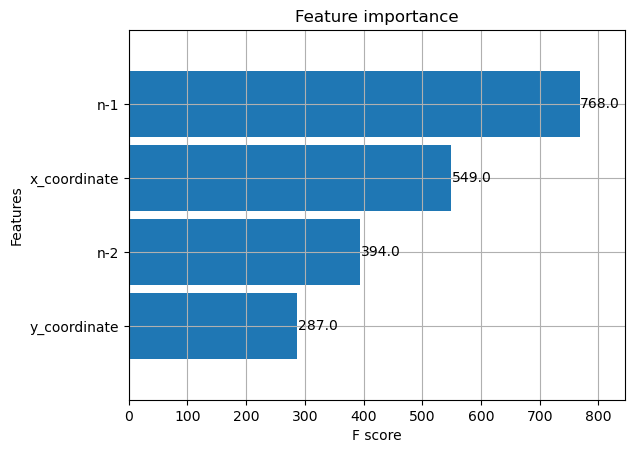

In [156]:
model.set_params(best_hyperparams)
model.fit()
model.feature_importance()

In [157]:
predicted_2019 = model.predict(2019)

In [158]:
data.addYearDemandfromForecast(2019, predicted_2019)

In [159]:
data.df_trans

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,16.710302
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,16.239906
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,17.565750
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,19.732737
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,18.497293
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,9.000040
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,2.827425
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,4.021677
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,9.618148


In [160]:
predicted_2020 = model.predict(2020)

In [161]:
data.addYearDemandfromForecast(2020, predicted_2020)

In [162]:
data.df_trans

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,16.710302,21.496117
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,16.239906,18.497293
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,17.565750,22.332476
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,19.732737,24.542948
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,18.497293,24.522871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,9.000040,13.245551
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,2.827425,3.593100
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,4.021677,4.920814
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,9.618148,13.314995


In [163]:
data.df_trans.to_csv("forecast.csv")